In [6]:
# Install required libraries and setup the notebook
!pip3 install pulp

import requests
url = 'https://raw.githubusercontent.com/NikoStein/CashLog/master/basicModel.py'
r = requests.get(url, allow_redirects=True)
open('basicModel.py', 'wb').write(r.content)

2848

# CashLog Basic Analysis

We will use this notebook to implement a basic version of CashLog's decision problem by performing the following steps:
1. Define and load relevent model parameters
2. Define and initialize the decision variables
3. Define and implement the objective function
3. Define and implement the relevant constraints
4. Solve the problem and anlyse the results
5. Perform sensitivity analysis

### Load the required libraries

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import folium
from tqdm import tqdm
from pulp import *

### The decision problem can be modeled in the sense of a MIP

In [8]:
prob = LpProblem('CashLog_BasicAnalysis', LpMinimize)

### Define and load model parameters

$W:$ Set of warehouses<br>
$R:$ Set of customer regions<br>
$S:$ Set of links between warehouses and regions<br>

$f_i:$ Fixed costs of warehouse $i$<br>
$c_{ij}:$ Costs if region $j$ is served by warehouse $i$<br>

In [9]:
warehouses = pd.read_csv('https://raw.githubusercontent.com/NikoStein/CashLog/master/data/warehouses.csv', index_col='warehouseID')
W = warehouses.index.values

regions = pd.read_csv('https://raw.githubusercontent.com/NikoStein/CashLog/master/data/regions.csv', index_col='regionID')
R = regions.index.values

shifts = pd.read_csv('https://raw.githubusercontent.com/NikoStein/CashLog/master/data/shifts.csv', index_col=['warehouseID', 'regionID'])
S = shifts.index.values

### Define and initialize the decision variables

$x_{ij}:$ Binary variable indicating if region $j$ is served by warehouse $i$<br> 
$y_{i}:$ Binary variable indicating if warehouse $i$ is opened<br>

In [12]:
x = LpVariable.dicts(name='x', indices=S, cat=LpBinary)
y = LpVariable.dicts(name='y', indices=W, cat=LpBinary)

### Define and implement the objective function

We want to minimize the total network costs (fixed costs + variable costs):

$$\min \sum_{i\in W}\sum_{j\in R} x_{ij} c_{ij} + \sum_{i\in W} f_i y_i$$

In [13]:
variableCosts = lpSum([x[i,j] * shifts.loc[i,j].transportationCosts for i,j in S]) 
fixedCosts = lpSum([y[i] * warehouses.loc[i].fixedCosts for i in W])

prob += fixedCosts + variableCosts

### Define and implement the relevant constraints

Regions can only be served by open warehouses:<br>
$$x_{ij} <= y_{i} \quad \forall i\in W, j\in R$$

Each region has to be served by exactly one warehouse:<br>
$$\sum_{i\in W} x_{ij} = 1 \quad \forall j\in R$$

In [14]:
for i in W:
    for j in R:
        prob += x[i,j] <= y[i]

for j in R:
    prob += lpSum([x[i,j] for i in W]) == 1

### Solve the problem and analyze the results

In [15]:
status = prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/be3e1d043d33450182c4747808f3dd9f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/be3e1d043d33450182c4747808f3dd9f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22150 COLUMNS
At line 152057 RHS
At line 174203 BOUNDS
At line 195876 ENDATA
Problem MODEL has 22145 rows, 21672 columns and 64890 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.86319e+07 - 2.50 seconds
Cgl0004I processed model has 22145 rows, 21672 columns (21672 integer (21672 of which binary)) and 64890 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.86319e+07
Cbc0038I 

In [16]:
fixedCosts = sum([y[i].varValue * warehouses.loc[i].fixedCosts for i in W])
variableCosts = sum([x[i,j].varValue * shifts.loc[i,j].transportationCosts for i,j in S])
print('Minimal costs are {:0,.0f} Euro'.format(prob.objective.value()))
print('Variable Costs: {:0,.0f}€\nFixed costs: {:0,.0f}€'.format(variableCosts,
                                                                 fixedCosts))
print('To minimize costs the following warehouses should be closed:')
for i in W:
    if y[i].varValue <= 0.1:
        print('   -{}'.format(warehouses.loc[i].city))

Minimal costs are 98,631,921 Euro
Variable Costs: 66,267,921€
Fixed costs: 32,364,000€
To minimize costs the following warehouses should be closed:
   -Albacete
   -Barcelona
   -Ciudad real
   -La coruña
   -Granada
   -San sebastian
   -Lerida
   -La rioja
   -Madrid
   -Navarra
   -Oviedo
   -Palencia
   -Pontevedra
   -Salamanca
   -Santander
   -Segovia
   -Sevilla
   -Soria
   -Toledo
   -Valencia
   -Valladolid
   -Bilbao
   -Zamora
   -Zaragoza


### Perform sensitivity analysis

To perform sensitivity analysis and get a deeper understanding of the optimal decisions we solve multiple instances of the problem. In order to have a clean notebook we outsourced the model and import it for the analysis.

We can instantiate an instance of the model via the ```CashLogWLP``` class and specify the costs per shift.

In [17]:
from basicModel import CashLogWLP

In [18]:
wlp = CashLogWLP()
wlp.solve(n_warehouses=-1)
print('Minimal costs are {:0,.0f} Euro'.format(wlp.totalCosts))
print('Variable Costs: {:0,.0f}€\nFixed costs: {:0,.0f}€'.format(wlp.variableCosts,
                                                                 wlp.fixedCosts))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/17983238ec814a26b1f3dcc99dc9cb6c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/17983238ec814a26b1f3dcc99dc9cb6c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22150 COLUMNS
At line 152057 RHS
At line 174203 BOUNDS
At line 195876 ENDATA
Problem MODEL has 22145 rows, 21672 columns and 64890 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.86319e+07 - 2.53 seconds
Cgl0004I processed model has 22145 rows, 21672 columns (21672 integer (21672 of which binary)) and 64890 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.86319e+07
Cbc0038I 

We can visualize the results of our optimization on a map:

In [19]:
plot_df_regions = pd.DataFrame(wlp.region_results)
plot_df_warehouses = pd.DataFrame(wlp.warehouse_results)
plot_df_warehouses = plot_df_warehouses[plot_df_warehouses.open == 1]
palette = sns.color_palette(None, len(wlp.W)).as_hex()
palette = {wlp.W[i]: palette[i] for i in range(len(wlp.W))}

m = folium.Map(location=[41, -4], zoom_start=6)
plot_df_regions.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                radius=4000, fill=False, popup=row['city'],
                                                color=palette[row['warehouseID']]).add_to(m), axis=1)
plot_df_warehouses.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                   radius=10000, fill=True, popup=row['city'],
                                                   color=palette[row['warehouseID']], 
                                                   fill_opacity=1).add_to(m), axis=1)
m

Additionally, we implemented new constraints in order to force the model to open a given number of warehouses or to open specific warehouese. E.g., we can solve a version of the model where the main facilities in Barcelona and Madrid are required to remain open.

In [20]:
# Run this cell to find warehouse IDs (Barcelona:8, Madrid: 28)
#wlp.warehouses['city']

In [21]:
wlp = CashLogWLP()
wlp.solve(n_warehouses=-1, force_open=[8, 28])
print('Minimal costs are {:0,.0f} Euro'.format(wlp.totalCosts))
print('Variable Costs: {:0,.0f}€\nFixed costs: {:0,.0f}€'.format(wlp.variableCosts,
                                                                 wlp.fixedCosts))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/0aa1dbaeec6240be99faa99f413682d4-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/0aa1dbaeec6240be99faa99f413682d4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22152 COLUMNS
At line 152061 RHS
At line 174209 BOUNDS
At line 195882 ENDATA
Problem MODEL has 22147 rows, 21672 columns and 64892 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.42656e+08 - 0.22 seconds
Cgl0004I processed model has 21115 rows, 21155 columns (21155 integer (21155 of which binary)) and 62315 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.42656e+08
Cbc0038I 

In [22]:
plot_df_regions = pd.DataFrame(wlp.region_results)
plot_df_warehouses = pd.DataFrame(wlp.warehouse_results)
plot_df_warehouses = plot_df_warehouses[plot_df_warehouses.open == 1]
palette = sns.color_palette(None, len(wlp.W)).as_hex()
palette = {wlp.W[i]: palette[i] for i in range(len(wlp.W))}

m = folium.Map(location=[41, -4], zoom_start=6)
plot_df_regions.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                radius=4000, fill=False, popup=row['city'],
                                                color=palette[row['warehouseID']]).add_to(m), axis=1)
plot_df_warehouses.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                   radius=10000, fill=True, popup=row['city'],
                                                   color=palette[row['warehouseID']], 
                                                   fill_opacity=1).add_to(m), axis=1)
m

We can use the new implementation to solve various versions of the problem and get a deeper understanding of the trade-off between fixed and variable costs:


  0%|                                                                                                                                                               | 0/31 [00:00<?, ?it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/f37173aced8148668ae5988949ad8b3c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/f37173aced8148668ae5988949ad8b3c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.20215e+08 - 0.13 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.20215e+08
Cbc0038I 


  3%|████▊                                                                                                                                                  | 1/31 [00:03<01:36,  3.23s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/d28cfe5081584a9a91dfd0b28bee7556-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/d28cfe5081584a9a91dfd0b28bee7556-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.06015e+08 - 0.11 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 436 integers unsatisfied sum - 218
Cbc0038I Pass   1: (0.88 seconds) suminf.  1


  6%|█████████▋                                                                                                                                             | 2/31 [00:09<02:27,  5.08s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/62fb9cc0f39a4252beae642c0527179b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/62fb9cc0f39a4252beae642c0527179b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.01941e+08 - 0.09 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.01941e+08
Cbc0038I 


 10%|██████████████▌                                                                                                                                        | 3/31 [00:12<01:57,  4.21s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/188f7e132f054382bdd02001516807a7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/188f7e132f054382bdd02001516807a7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.00462e+08 - 0.09 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.00462e+08
Cbc0038I 


 13%|███████████████████▍                                                                                                                                   | 4/31 [00:16<01:43,  3.83s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/30fab97b19be47bfa68335df5a1b8f50-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/30fab97b19be47bfa68335df5a1b8f50-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.94632e+07 - 0.09 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.94632e+07
Cbc0038I 


 16%|████████████████████████▎                                                                                                                              | 5/31 [00:19<01:35,  3.66s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/f98efac2ee784219919a5dced08562e6-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/f98efac2ee784219919a5dced08562e6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.90397e+07 - 0.09 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.90397e+07
Cbc0038I 


 19%|█████████████████████████████▏                                                                                                                         | 6/31 [00:22<01:27,  3.50s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/631bd94afc974bd5a04ea9bd3b5b281f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/631bd94afc974bd5a04ea9bd3b5b281f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.86319e+07 - 0.08 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.86319e+07
Cbc0038I 


 23%|██████████████████████████████████                                                                                                                     | 7/31 [00:25<01:21,  3.41s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/6772df29fd17409ea358847bc03f8b0a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/6772df29fd17409ea358847bc03f8b0a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.87005e+07 - 0.08 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.87005e+07
Cbc0038I 


 26%|██████████████████████████████████████▉                                                                                                                | 8/31 [00:29<01:18,  3.40s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/43ff045fd49c42c98abbf83284b57691-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/43ff045fd49c42c98abbf83284b57691-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.92615e+07 - 0.06 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 9.92615e+07
Cbc0038I 


 29%|███████████████████████████████████████████▊                                                                                                           | 9/31 [00:32<01:14,  3.37s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/66191c1f89e045dfa727736ac35246e8-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/66191c1f89e045dfa727736ac35246e8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.00069e+08 - 0.05 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.00069e+08
Cbc0038I 


 32%|████████████████████████████████████████████████▍                                                                                                     | 10/31 [00:35<01:08,  3.27s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/2639dd1708ac4ed7bb38d7f6ffbd0038-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/2639dd1708ac4ed7bb38d7f6ffbd0038-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.01084e+08 - 0.06 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.01084e+08
Cbc0038I 


 35%|█████████████████████████████████████████████████████▏                                                                                                | 11/31 [00:38<01:04,  3.21s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/9a6fa389c5c341c8928b8a5695fe666d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/9a6fa389c5c341c8928b8a5695fe666d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.02136e+08 - 0.06 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.02136e+08
Cbc0038I 


 39%|██████████████████████████████████████████████████████████                                                                                            | 12/31 [00:41<01:00,  3.17s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/d5a9756b1dfc41fc99cf4e13997ba813-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/d5a9756b1dfc41fc99cf4e13997ba813-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.03193e+08 - 0.05 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.03193e+08
Cbc0038I 


 42%|██████████████████████████████████████████████████████████████▉                                                                                       | 13/31 [00:44<00:56,  3.11s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/cf6cc7b1b1fd47cea10ff585b8a6e1a7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/cf6cc7b1b1fd47cea10ff585b8a6e1a7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.04474e+08 - 0.04 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.04474e+08
Cbc0038I 


 45%|███████████████████████████████████████████████████████████████████▋                                                                                  | 14/31 [00:47<00:52,  3.10s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/1a2809a3c176430694be2b47d4b1b0f6-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/1a2809a3c176430694be2b47d4b1b0f6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.05969e+08 - 0.04 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.05969e+08
Cbc0038I 


 48%|████████████████████████████████████████████████████████████████████████▌                                                                             | 15/31 [00:50<00:49,  3.09s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/cdc11fe6391641d68aba5bcb00c44041-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/cdc11fe6391641d68aba5bcb00c44041-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.07514e+08 - 0.04 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.07514e+08
Cbc0038I 


 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                        | 16/31 [00:53<00:45,  3.06s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/137b6e40ca3b47fd9298bf4eb71ffa41-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/137b6e40ca3b47fd9298bf4eb71ffa41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.0914e+08 - 0.04 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.0914e+08
Cbc0038I Be


 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                   | 17/31 [00:56<00:42,  3.05s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/5cd4ca8511804f4f833d60ab70476902-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/5cd4ca8511804f4f833d60ab70476902-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.10788e+08 - 0.04 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.10788e+08
Cbc0038I 


 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 18/31 [00:59<00:39,  3.05s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/696a1ae0ab4943f1ba457f01d30bd5e3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/696a1ae0ab4943f1ba457f01d30bd5e3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.1287e+08 - 0.04 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.1287e+08
Cbc0038I Be


 61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19/31 [01:02<00:36,  3.05s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/bfd6514159b744a3b2cf041d93219eb9-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/bfd6514159b744a3b2cf041d93219eb9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.14976e+08 - 0.03 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.14976e+08
Cbc0038I 


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 20/31 [01:06<00:34,  3.10s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/14a699d3799d4456b28968f3f8bb0947-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/14a699d3799d4456b28968f3f8bb0947-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.17255e+08 - 0.04 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.17255e+08
Cbc0038I 


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 21/31 [01:09<00:31,  3.14s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/9a8364cee6ca497f806b88f1264f1bb1-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/9a8364cee6ca497f806b88f1264f1bb1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.19621e+08 - 0.03 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.19621e+08
Cbc0038I 


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 22/31 [01:12<00:28,  3.14s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/3320ddfc4d6b4935a4f844208ec9f9c6-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/3320ddfc4d6b4935a4f844208ec9f9c6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.21988e+08 - 0.03 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.21988e+08
Cbc0038I 


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 23/31 [01:15<00:24,  3.11s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/266f6db8a9764e5189dab91dcb86ef04-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/266f6db8a9764e5189dab91dcb86ef04-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.24416e+08 - 0.04 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.24416e+08
Cbc0038I 


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 24/31 [01:18<00:21,  3.10s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/bb50928066514694a46b8c32420c4bf9-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/bb50928066514694a46b8c32420c4bf9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.26856e+08 - 0.03 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.26856e+08
Cbc0038I 


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 25/31 [01:21<00:18,  3.13s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/b5c44b55740a4d668f034f1057b73bb3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/b5c44b55740a4d668f034f1057b73bb3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.30194e+08 - 0.03 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.30194e+08
Cbc0038I 


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 26/31 [01:24<00:15,  3.12s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/8aecc61df38343e389b9eb74e5a8fff8-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/8aecc61df38343e389b9eb74e5a8fff8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.33784e+08 - 0.03 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.33784e+08
Cbc0038I 


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 27/31 [01:28<00:12,  3.12s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/65f4918fdf084c519d0934e7e36c4502-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/65f4918fdf084c519d0934e7e36c4502-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.37685e+08 - 0.03 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.37685e+08
Cbc0038I 


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 28/31 [01:31<00:09,  3.10s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/abed105552504094b6bddac7a2f31d90-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/abed105552504094b6bddac7a2f31d90-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.41828e+08 - 0.02 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.41828e+08
Cbc0038I 


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 29/31 [01:34<00:06,  3.06s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/67a6375c43944154a17e91bd015945e3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/67a6375c43944154a17e91bd015945e3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.55198e+08 - 0.03 seconds
Cgl0004I processed model has 22146 rows, 21672 columns (21672 integer (21672 of which binary)) and 64932 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.55198e+08
Cbc0038I 


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 30/31 [01:37<00:03,  3.03s/it]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/felix/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/d7b1b08fe94e4e369ee240dec31fa28e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6j/gn7pdqm11j301ydr2rtrjpd00000gn/T/d7b1b08fe94e4e369ee240dec31fa28e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22151 COLUMNS
At line 152100 RHS
At line 174247 BOUNDS
At line 195920 ENDATA
Problem MODEL has 22146 rows, 21672 columns and 64932 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.89119e+08 - 0.01 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 1.89119e+08 to -1.79769e+308
Probing 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:39<00:00,  3.21s/it]


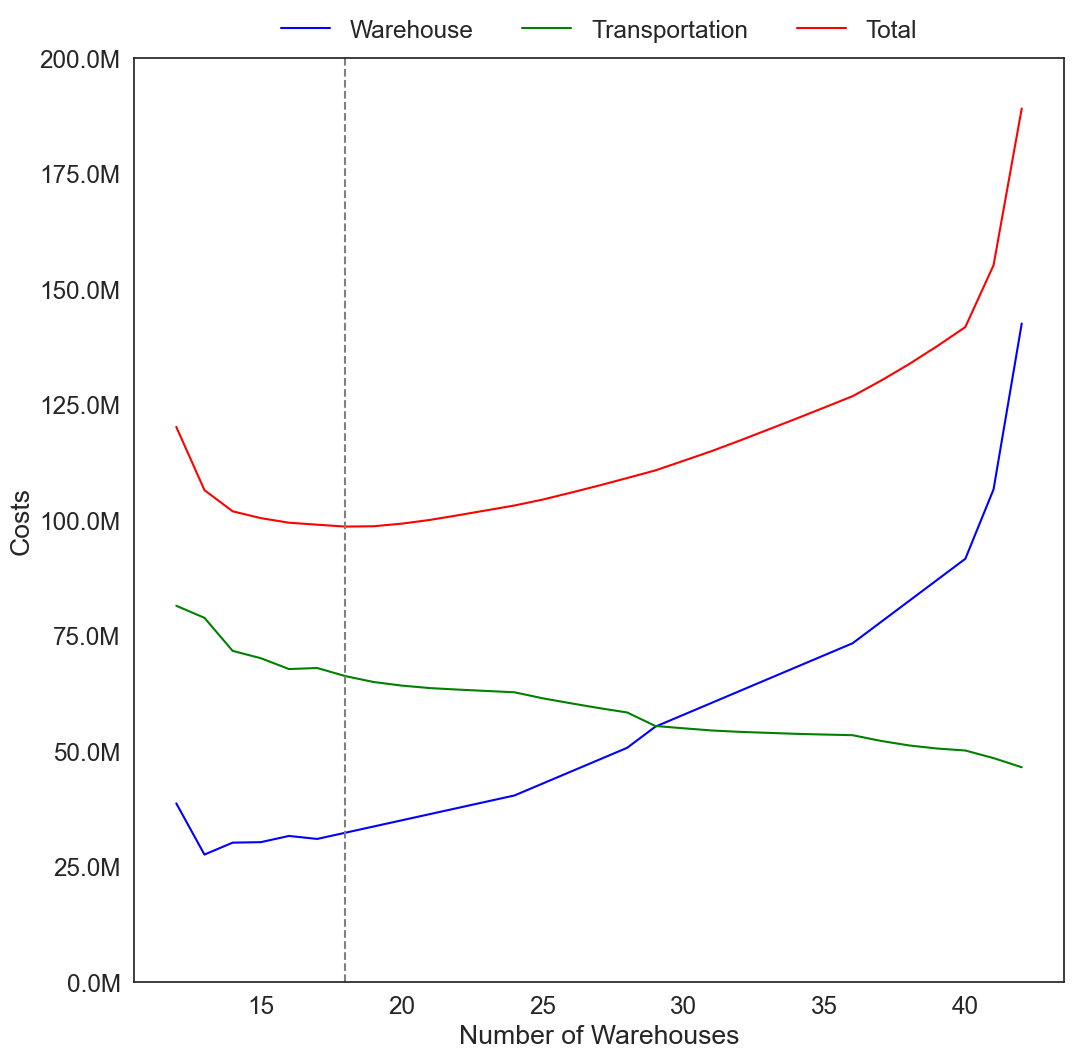

In [23]:
cFixed = {}
cVariable = {}
cTotal = {}
warehouse_results = {}
region_results = {}

wlp = CashLogWLP()

for n in tqdm(range(12, len(wlp.W)+1, 1)):
    wlp.solve(n_warehouses=n)
    cFixed[n] = wlp.fixedCosts
    cVariable[n] = wlp.variableCosts
    cTotal[n] = wlp.totalCosts
    warehouse_results[n] = wlp.warehouse_results
    region_results[n] = wlp.region_results

results_df = pd.DataFrame({'fixed':cFixed, 'transportation':cVariable, 'total':cTotal})
min_costs_n = results_df.total.idxmin()
results_df.reset_index(inplace=True)
plot_df = pd.melt(results_df, id_vars='index', value_vars=['fixed', 'transportation', 'total'])



def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)
plot_df.replace(['fixed', 'transportation', 'total'], ['Warehouse', 'Transportation', 'Total'], inplace=True)
sns.set(font_scale=1.6)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(12, 12))
g = sns.lineplot(data=plot_df, x='index', y='value', hue='variable', palette={'Warehouse': 'blue', 
                                                                              'Transportation': 'green', 
                                                                              'Total': 'red'})
g.axvline(min_costs_n, c='grey', linestyle='--')
ax.set_ylim(0,200000000)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Number of Warehouses')
ax.set_ylabel("Costs")
ax.legend(bbox_to_anchor=[0.5,1.03], loc='center', ncol=3, frameon=False)

Again, we can visualize the results on a map and compare the different region-warehouse allocations depending on the number of open warehouses:

In [25]:
def map_results(n_warehouses):
    plot_df_regions = pd.DataFrame(region_results[n_warehouses])
    plot_df_warehouses = pd.DataFrame(warehouse_results[n_warehouses])
    plot_df_warehouses = plot_df_warehouses[plot_df_warehouses.open == 1]
    palette = sns.color_palette(None, len(wlp.W)).as_hex()
    palette = {wlp.W[i]: palette[i] for i in range(len(wlp.W))}

    m = folium.Map(location=[41, -4], zoom_start=6)
    plot_df_regions.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                    radius=4000, fill=False, popup=row['city'],
                                                    color=palette[row['warehouseID']]).add_to(m), axis=1)
    plot_df_warehouses.apply(lambda row: folium.Circle(location=[row['lat'], row['lon']], 
                                                       radius=10000, fill=True, popup=row['city'],
                                                       color=palette[row['warehouseID']], 
                                                       fill_opacity=1).add_to(m), axis=1)
    return m

In [26]:
map_results(n_warehouses=42)

In [27]:
map_results(n_warehouses=18)

In [30]:
map_results(n_warehouses=30)